<a href="https://colab.research.google.com/github/Niloy-24/Transfer-Learning-Based-Classification-Of-Eye-Disease/blob/main/Mobilenet_NormalVsEyelid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
PATH = '/content/gdrive/MyDrive/Thesis/Data/NormalVsEyelid/'
train_dir = os.path.join(PATH, 'Train')
test_dir = os.path.join(PATH, 'Test')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 1519 files belonging to 2 classes.


In [ ]:
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                           shuffle=True,
                                                           batch_size=BATCH_SIZE,
                                                           image_size=IMG_SIZE)

Found 363 files belonging to 2 classes.


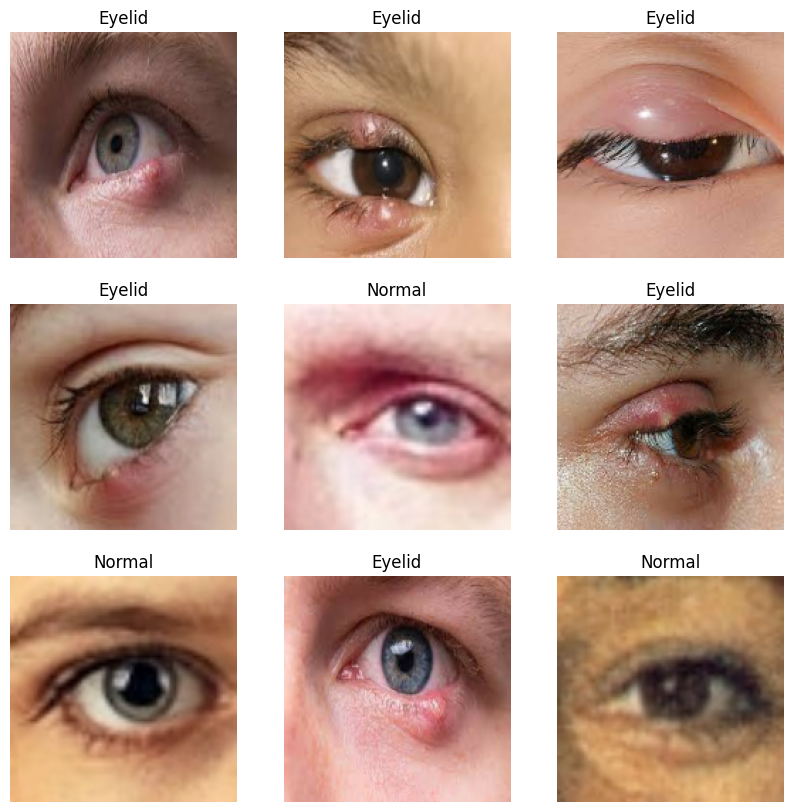

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
test_batches = tf.data.experimental.cardinality(test_dataset)
val_dataset = test_dataset.take(test_batches // 7)
val_dataset = test_dataset.skip(test_batches // 7)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 11
Number of test batches: 12


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

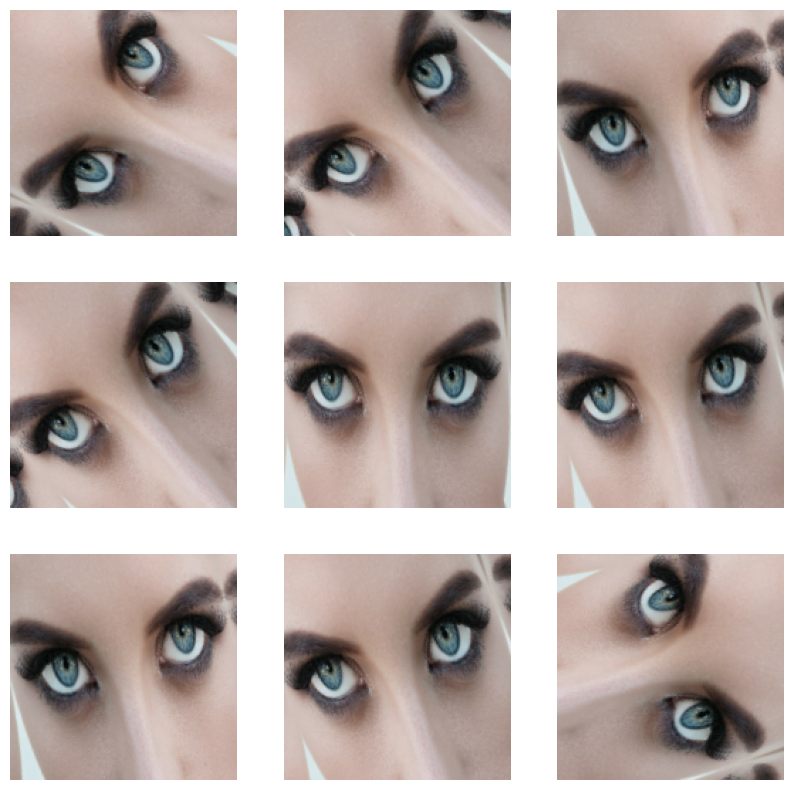

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 1s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
len(model.trainable_variables)

2

In [ ]:
initial_epochs = 50
loss0, accuracy0 = model.evaluate(val_dataset)

11/11 [==============================] - 118s 2s/step - loss: 7.5678 - accuracy: 0.4290


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 7.57
initial accuracy: 0.43


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=val_dataset)

Epoch 1/50
48/48 [==============================] - 214s 4s/step - loss: 5.8315 - accuracy: 0.5194 - val_loss: 7.0185 - val_accuracy: 0.4109
Epoch 2/50
48/48 [==============================] - 4s 82ms/step - loss: 4.2008 - accuracy: 0.6030 - val_loss: 5.6480 - val_accuracy: 0.4109
Epoch 3/50
48/48 [==============================] - 6s 112ms/step - loss: 3.5335 - accuracy: 0.6485 - val_loss: 5.3873 - val_accuracy: 0.4018
Epoch 4/50
48/48 [==============================] - 4s 83ms/step - loss: 2.9541 - accuracy: 0.6985 - val_loss: 5.6179 - val_accuracy: 0.4018
Epoch 5/50
48/48 [==============================] - 4s 76ms/step - loss: 2.5972 - accuracy: 0.7182 - val_loss: 5.3908 - val_accuracy: 0.4199
Epoch 6/50
48/48 [==============================] - 6s 110ms/step - loss: 2.5262 - accuracy: 0.7248 - val_loss: 5.2481 - val_accuracy: 0.4109
Epoch 7/50
48/48 [==============================] - 4s 81ms/step - loss: 2.3876 - accuracy: 0.7571 - val_loss: 5.1006 - val_accuracy: 0.4381
Epoch 8/50


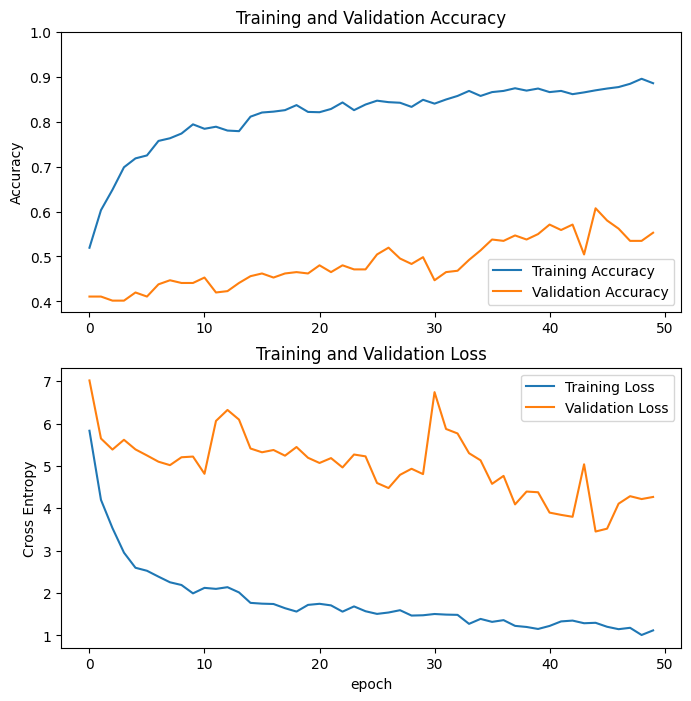

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in model.layers[fine_tune_at:]:
  layer.trainable = True

Number of layers in the base model:  8


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
len(model.trainable_variables)

158

In [ ]:
fine_tune_epochs = 50
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_dataset)

Epoch 50/100
48/48 [==============================] - 34s 139ms/step - loss: 1.1669 - accuracy: 0.8887 - val_loss: 4.8841 - val_accuracy: 0.5287
Epoch 51/100
48/48 [==============================] - 6s 127ms/step - loss: 0.8667 - accuracy: 0.9171 - val_loss: 1.5902 - val_accuracy: 0.8187
Epoch 52/100
48/48 [==============================] - 6s 110ms/step - loss: 0.5061 - accuracy: 0.9454 - val_loss: 1.6386 - val_accuracy: 0.8097
Epoch 53/100
48/48 [==============================] - 7s 150ms/step - loss: 0.5665 - accuracy: 0.9355 - val_loss: 1.2633 - val_accuracy: 0.8761
Epoch 54/100
48/48 [==============================] - 6s 114ms/step - loss: 0.4257 - accuracy: 0.9533 - val_loss: 1.7741 - val_accuracy: 0.8248
Epoch 55/100
48/48 [==============================] - 6s 117ms/step - loss: 0.3695 - accuracy: 0.9651 - val_loss: 2.6235 - val_accuracy: 0.7704
Epoch 56/100
48/48 [==============================] - 6s 108ms/step - loss: 0.3704 - accuracy: 0.9664 - val_loss: 2.5044 - val_accuracy

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

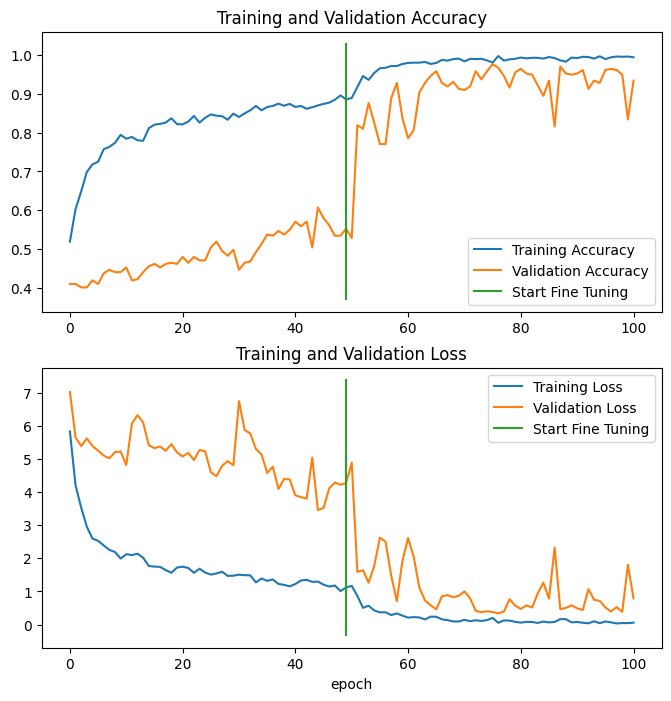

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

12/12 [==============================] - 2s 83ms/step - loss: 0.7194 - accuracy: 0.9394
Test accuracy : 0.939393937587738


Predictions:
 [0 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 1 1 1 1 1 1 0 0 1 0 1 0 0 1 0 1]
Labels:
 [0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1]


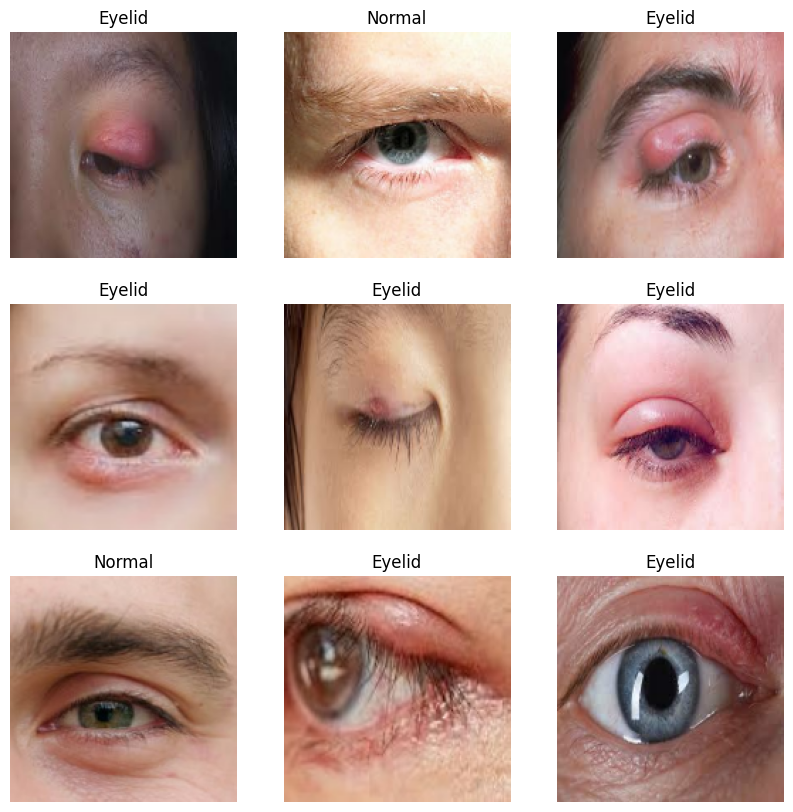

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")